Cost of Attrition: **Weighted Sum/Average Method** to calculate individual EEV

Bins (cut points): [ 0.991  4.     7.    10.   ]
0          Low
1         High
2          Low
3          Low
4          Low
         ...  
1465    Medium
1466       Low
1467    Medium
1468       Low
1469       Low
Name: PerformanceBand, Length: 1470, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']


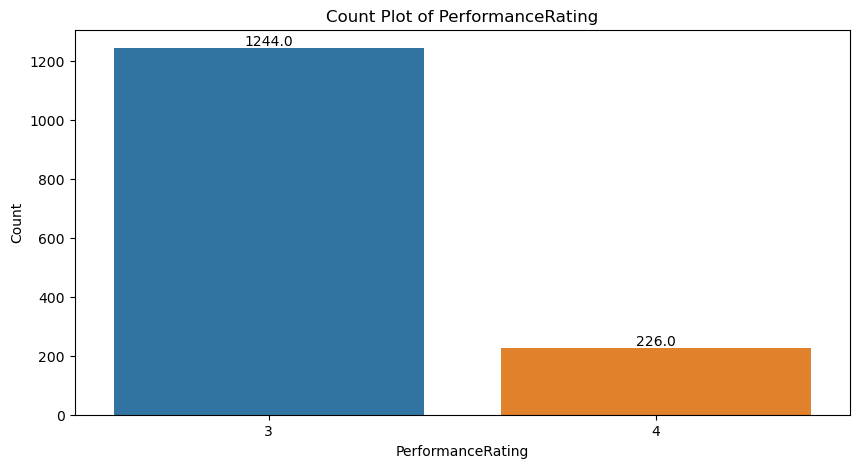

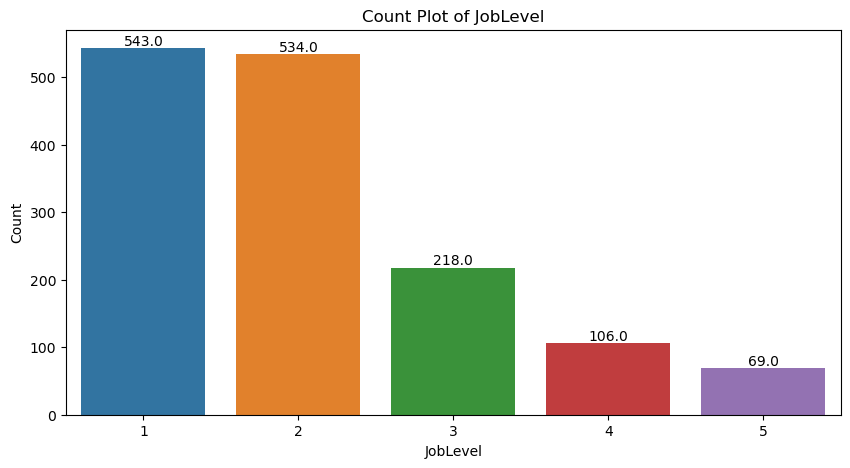

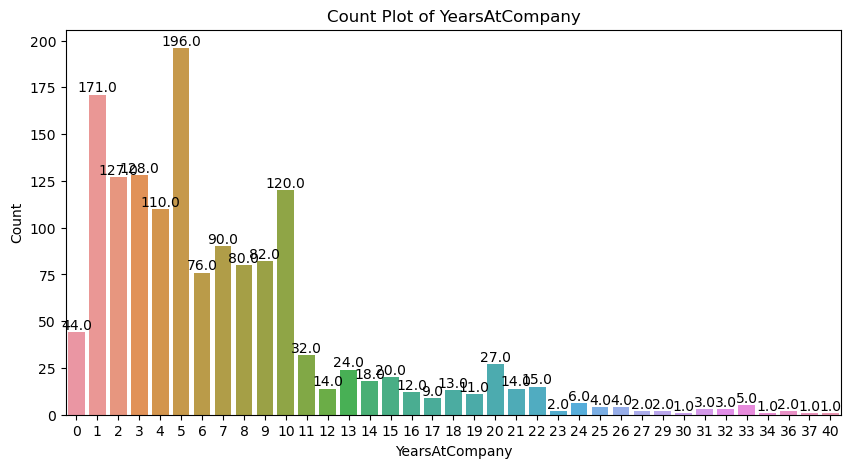

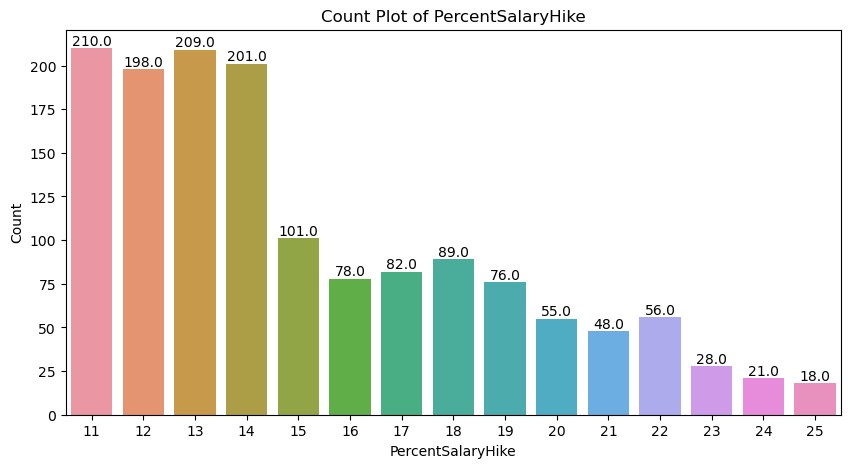

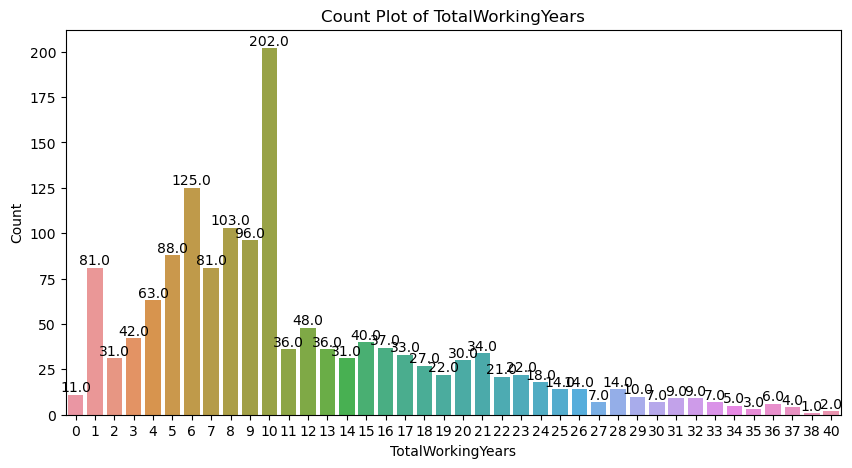

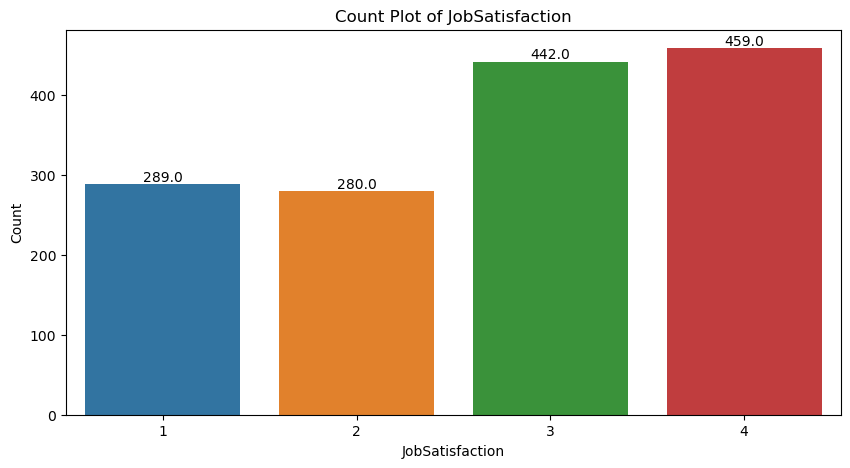

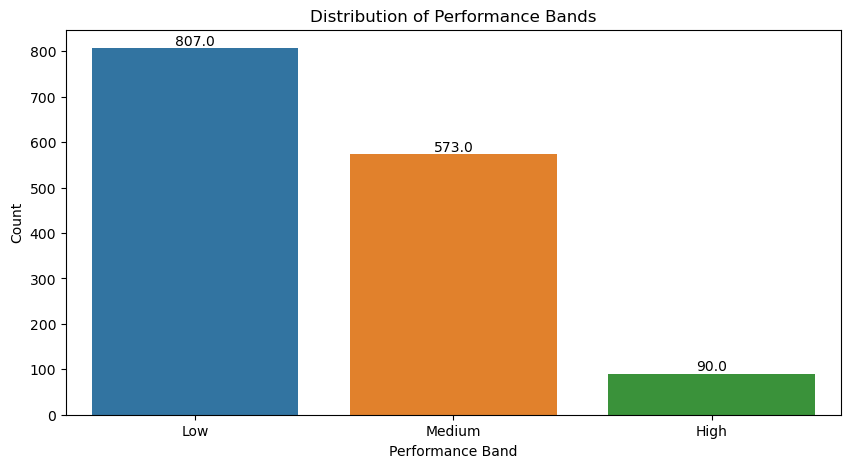

,PerformanceRating,JobLevel,YearsAtCompany,PercentSalaryHike,TotalWorkingYears,JobSatisfaction,WeightedScore,Performance,PerformanceBand,MonthlyIncome
0,3,2,6,11,8,4,2.728930,1.0,Low,5993
1,4,2,10,23,10,2,7.056425,8.8,High,5130
2,3,1,0,15,7,3,3.270998,3.4,Low,2090
3,3,1,8,11,8,3,2.190093,1.0,Low,2909
4,3,1,2,12,6,2,1.916152,1.6,Low,3468


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('./IBM’s Employee Life Cycle.csv')

# Selecting relevant columns
features = ['PerformanceRating', 'JobLevel', 'YearsAtCompany', 'PercentSalaryHike', 'TotalWorkingYears', 'JobSatisfaction']

# Assign weights to each feature
weights = {
    'PercentSalaryHike': 0.25,
    'PerformanceRating': 0.25,
    'YearsAtCompany': 0.15,
    'TotalWorkingYears': 0.15,
    'JobLevel': 0.10,
    'JobSatisfaction': 0.10
}

# Calculate weighted score
df['WeightedScore'] = (
    df['PercentSalaryHike'] * weights['PercentSalaryHike'] +
    df['PerformanceRating'] * weights['PerformanceRating'] +
    df['YearsAtCompany'] * weights['YearsAtCompany'] +
    df['TotalWorkingYears'] * weights['TotalWorkingYears'] +
    df['JobLevel'] * weights['JobLevel'] +
    df['JobSatisfaction'] * weights['JobSatisfaction']
)


# Ensure no NaN values in WeightedScore
df['WeightedScore'] = df['WeightedScore'].fillna(0)

def normalize(x):
    x = 1 + (9 * (x - min(x))) / (max(x)- min(x))
    return x

df['Performance'] = df['PercentSalaryHike'] + df['PerformanceRating']
df['Experience'] = df['YearsAtCompany'] + df['TotalWorkingYears']
df['Environment'] = df['JobLevel'] + df['JobSatisfaction']
df['Performance'] = normalize(df['Performance'])
df['Experience'] = normalize(df['Experience'])
df['Environment'] = normalize(df['Environment'])

df['WeightedScore'] = (
    df['Performance'] * 0.5 +
    df['Experience'] * 0.3 +
    df['Environment'] * 0.2
)

df['WeightedScore'] = normalize(df['WeightedScore'])

# Equal-width binning with retbins=True to get bin edges
df['PerformanceBand'], bins = pd.cut(df['WeightedScore'], bins=3, labels=['Low', 'Medium', 'High'], retbins=True)

# Display the bins (equal-width binning)
print("Bins (cut points):", bins)

# Display the bins (equal-width binning)
print(df['PerformanceBand'])

# Visualize each factor
def plot_factors(df):
    for feature in features:
        plt.figure(figsize=(10, 5))
        sns.countplot(x=feature, data=df)
        plt.title(f'Count Plot of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
        for p in plt.gca().patches:
            plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        plt.show()

# Visualize the weighted score distribution
def plot_weighted_score(df, bins):
    plt.figure(figsize=(10, 5))
    sns.histplot(df['WeightedScore'], bins=10, kde=True)
    plt.title('Histogram of Weighted Scores')
    plt.xlabel('Weighted Score')
    plt.ylabel('Frequency')

    # Annotate quantile boundaries
    for q in bins:
        plt.axvline(q, color='r', linestyle='--')

    mean_val = df['WeightedScore'].mean()
    median_val = df['WeightedScore'].median()
    plt.axvline(mean_val, color='r', linestyle='-', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='g', linestyle='-', label=f'Median: {median_val:.2f}')
    plt.legend()
    plt.show()

# Visualize the performance bands
def plot_performance_bands(df):
    plt.figure(figsize=(10, 5))
    sns.countplot(x='PerformanceBand', data=df, order=['Low', 'Medium', 'High'])
    plt.title('Distribution of Performance Bands')
    plt.xlabel('Performance Band')
    plt.ylabel('Count')
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    plt.show()

# Plot each factor
plot_factors(df)

# Plot performance bands
plot_performance_bands(df)

# Display the resulting dataframe
df[['PerformanceRating', 'JobLevel', 'YearsAtCompany', 'PercentSalaryHike', 'TotalWorkingYears', 'JobSatisfaction', 'WeightedScore', 'Performance', 'PerformanceBand', 'MonthlyIncome']].head()

In [8]:
max(df['WeightedScore'])

10.0

(array([ 64., 289., 356., 266., 199., 140.,  89.,  35.,  24.,   8.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

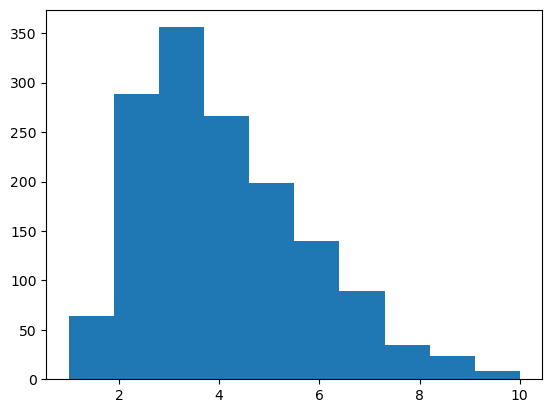

In [9]:
plt.hist(df['WeightedScore'])

In [10]:
df['PerformanceBand'].value_counts()

PerformanceBand
Low       807
Medium    573
High       90
Name: count, dtype: int64

**Calculating cost of attrition w.r.t performance, % cost and MonthlyIncome

In [12]:
def calculateCost(monthlyIncome, performanceBand):
    if(performanceBand == 'High'):
        return 2.5 * monthlyIncome * 12
    elif(performanceBand == 'Medium'):
        return 1.5 * monthlyIncome * 12
    elif(performanceBand == 'Low'):
        return 1.0 * monthlyIncome * 12
    
df['CostofAttrition'] = df.apply(lambda row: calculateCost(row['MonthlyIncome'], row['PerformanceBand']), axis = 1)

In [13]:
df[['PerformanceRating', 'JobLevel', 'YearsAtCompany', 'PercentSalaryHike', 'TotalWorkingYears', 'JobSatisfaction', 'WeightedScore', 'Performance', 'PerformanceBand', 'MonthlyIncome','Attrition', 'CostofAttrition']]

,PerformanceRating,JobLevel,YearsAtCompany,PercentSalaryHike,TotalWorkingYears,JobSatisfaction,WeightedScore,Performance,PerformanceBand,MonthlyIncome,Attrition,CostofAttrition
0,3,2,6,11,8,4,2.728930,1.0,Low,5993,Yes,71916.0
1,4,2,10,23,10,2,7.056425,8.8,High,5130,No,153900.0
2,3,1,0,15,7,3,3.270998,3.4,Low,2090,Yes,25080.0
3,3,1,8,11,8,3,2.190093,1.0,Low,2909,No,34908.0
4,3,1,2,12,6,2,1.916152,1.6,Low,3468,No,41616.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1465,3,2,5,17,17,4,5.225413,4.6,Medium,2571,No,46278.0
1466,3,3,7,15,9,1,3.637330,3.4,Low,9991,No,119892.0
1467,4,2,6,20,6,2,5.645370,7.0,Medium,6142,No,110556.0
1468,3,2,9,14,17,2,3.682556,2.8,Low,5390,No,64680.0


** Attrition Cost in Bands**

In [ ]:
#Return Total cost of attrition, total number of employees, average cost of attrition per employee
sum = 0
def totalcostofattrition(df, performanceBand):
    df = df[(df['Attrition'] == 'Yes') & (df['PerformanceBand'] == performanceBand)]
    return df['CostofAttrition'].sum(), len(df), df['CostofAttrition'].sum()/ len(df)

In [15]:
HighPerformanceAttrition = totalcostofattrition(df, 'High')
LowPerformanceAttrition = totalcostofattrition(df, 'Low')
MediumPerformanceAttrition = totalcostofattrition(df, 'Medium')

In [ ]:
#Return Total cost of attrition, total number of employees, average cost of attrition per employee for High Performers
print(HighPerformanceAttrition)

(1722450.0, 7, 246064.2857142857)


In [ ]:
#Return Total cost of attrition, total number of employees, average cost of attrition per employee for Medium Performers
MediumPerformanceAttrition

(7425072.0, 70, 106072.45714285714)

In [ ]:
#Return Total cost of attrition, total number of employees, average cost of attrition per employee for Low Performers
LowPerformanceAttrition

(7975464.0, 160, 49846.65)

industry - cost of hiring a new staff for X Department (hence the 250%/150%/50%) used as a guage in costing. Our attrition cost is. New pax is this cost plus training cost etc. EEV to Cost Ratio. With the list calculated the cost is reflected and for management to decide. Let management decide based on their org culture and budget etc.

Total Cost ~ average cost / employee/ year